In [1]:
import gc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from utils import *

In [2]:
# Parameters
num_points = 200
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

# Function to generate circular distribution with a hole
def generate_annular_points(num_points, r_inner, r_outer):
    points = []
    for _ in range(num_points):
        # Generate random radius within the annular region
        r = np.sqrt(np.random.uniform(r_inner**2, r_outer**2))
        # Generate random angle
        theta = np.random.uniform(0, 2 * np.pi)
        # Convert polar to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        points.append((x, y))
    return torch.tensor(points, dtype=torch.float32)

# Function to generate spherical distribution with a hole in 3D
def generate_annular_points_3d(num_points, r_inner, r_outer):
    points = []
    for _ in range(num_points):
        # Generate random radius within the spherical shell
        r = np.cbrt(np.random.uniform(r_inner**3, r_outer**3))
        # Generate random angles for spherical coordinates
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuthal angle
        phi = np.arccos(np.random.uniform(-1, 1))  # Polar angle
        # Convert spherical to Cartesian coordinates
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        points.append((x, y, z))
    return torch.tensor(points, dtype=torch.float16)

In [3]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)

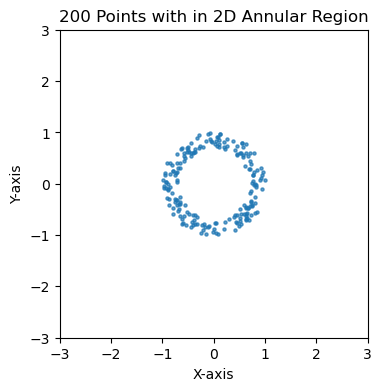

In [4]:
# Plotting the points
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'{num_points} Points with in 2D Annular Region')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
#plt.grid(True)
# set xlim and ylim
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [5]:
dm = DensityMetric(data, 0.05)
dm_energy = lambda _model, _curve: _model.curve_energy(_curve.points())

In [6]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

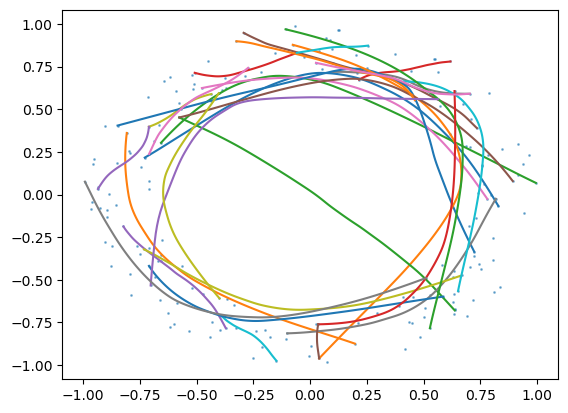

In [7]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=200)
batch_c.plot()
plt.show()

In [8]:
batch_c.euclidean_length().mean().item()

1.2659602165222168

In [18]:
# Function to embed 2D points into a 100D space with nonlinearity
def embed_points_2d_to_100d(points_2d):
    # Example non-linear transformations
    def nonlinear_map(x, y):
        features = []
        # Polynomial terms
        features.append(x)
        features.append(y)
        features.append(x**2)
        features.append(y**2)
        #features.append(torch.sqrt_(torch.abs(x)))
        #features.append(torch.sqrt_(torch.abs(y)))
#        features.append(x * y)
        # Trigonometric terms
#        features.append(np.sin(x))
#        features.append(np.cos(y))
#        features.append(np.sin(x * y))
        # More complex interactions
#        features.append(np.sqrt(np.abs(x * y)))
#        features.append(np.exp(-x**2 - y**2))
        # Expand to 100 dimensions by repeating patterns
        while len(features) < 100:
            features.append(features[len(features) % len(features)])  # Repeat patterns
        return np.array(features[:100])  # Truncate or pad to exactly 100 features

    # Apply the transformation to each 2D point
    points_100d = np.array([nonlinear_map(x, y) for x, y in points_2d])
    return points_100d

# create a dataset and a dataloader in which x is the data and y is the data_vae
class DumbDataset(torch.utils.data.Dataset):
    def __init__(self, z, y):
        self.z = z
        self.y = y
    def __len__(self):
        return len(self.z)
    def __getitem__(self, idx):
        return self.z[idx], self.y[idx]

In [19]:
data_vae = embed_points_2d_to_100d(data)
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((200, 100), 0.9939373, -0.9917287)

In [20]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

In [21]:
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=data_vae_3d[:, 0],
    y=data_vae_3d[:, 1],
    z=data_vae_3d[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.7
    )
)])
# set xlim and ylim
fig.update_layout(scene=dict(
    xaxis=dict(range=[-3, 3]),
    yaxis=dict(range=[-3, 3]),
    zaxis=dict(range=[-3, 3])
))
# Set plot title and axis labels
fig.update_layout(
    title=f'{num_points} Points in 3D Annular Region',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    )
)
# Show the plot
fig.show()

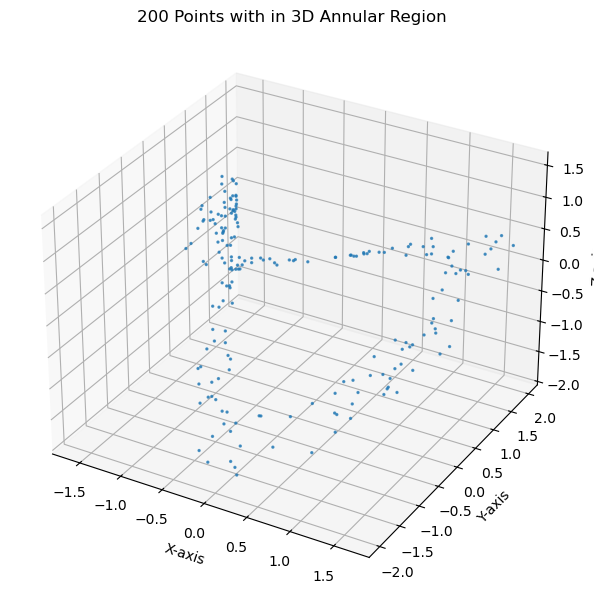

In [22]:
# Plotting the points
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data_vae_3d[:, 0], data_vae_3d[:, 1], data_vae_3d[:, 2], s=2, alpha=0.7)
ax.set_title(f'{num_points} Points with in 3D Annular Region')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.grid(True)

In [23]:
def get_decoder(z_dim=2):
    decoder_net = nn.Sequential(
        nn.Linear(z_dim, 10),
        nn.Tanh(),
        nn.Linear(10, 20),
        nn.Tanh(),
        nn.Linear(20, 50),
        nn.Tanh(),
        nn.Linear(50, 100),
        nn.Tanh(),
    )
    return decoder_net

In [24]:
model = get_decoder()
model.train();

In [25]:
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

100%|██████████| 40/40 [00:01<00:00, 36.84it/s]


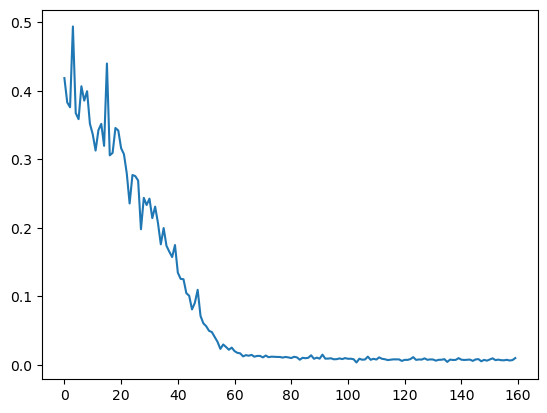

In [27]:
# plot the losses
plt.plot(losses)
plt.show()

In [28]:
## Put trained models in 'eval' mode
model.eval();

In [39]:
def generate_grid(v=2, grid_size=100, device=device):
    x_lin = torch.linspace(-v, v, grid_size).to(device)
    y_lin = torch.linspace(-v, v, grid_size).to(device)
    x_grid, y_grid = torch.meshgrid(x_lin, y_lin, indexing='ij')
    grid = torch.stack((x_grid, y_grid), dim=-1)
    return grid, x_lin.cpu(), y_lin.cpu()

grid_size = 50
z_grid, x_lin, y_lin = generate_grid(grid_size=grid_size)
# Print the resulting grid shape and a sample
print(f"Grid shape: {z_grid.shape}")  # Expected shape: (grid_size, grid_size, 2)

Grid shape: torch.Size([50, 50, 2])


In [46]:
z_grid[0]

tensor([[-2.0000, -2.0000],
        [-2.0000, -1.9184],
        [-2.0000, -1.8367],
        [-2.0000, -1.7551],
        [-2.0000, -1.6735],
        [-2.0000, -1.5918],
        [-2.0000, -1.5102],
        [-2.0000, -1.4286],
        [-2.0000, -1.3469],
        [-2.0000, -1.2653],
        [-2.0000, -1.1837],
        [-2.0000, -1.1020],
        [-2.0000, -1.0204],
        [-2.0000, -0.9388],
        [-2.0000, -0.8571],
        [-2.0000, -0.7755],
        [-2.0000, -0.6939],
        [-2.0000, -0.6122],
        [-2.0000, -0.5306],
        [-2.0000, -0.4490],
        [-2.0000, -0.3673],
        [-2.0000, -0.2857],
        [-2.0000, -0.2041],
        [-2.0000, -0.1224],
        [-2.0000, -0.0408],
        [-2.0000,  0.0408],
        [-2.0000,  0.1224],
        [-2.0000,  0.2041],
        [-2.0000,  0.2857],
        [-2.0000,  0.3673],
        [-2.0000,  0.4490],
        [-2.0000,  0.5306],
        [-2.0000,  0.6122],
        [-2.0000,  0.6939],
        [-2.0000,  0.7755],
        [-2.0000,  0

In [32]:
# compute the jacoian of the model with respect to the data
# Generate input data
#z_grid = torch.FloatTensor(np.random.uniform(-2, 2, size=(1000, 2))).to(device)
#with torch.no_grad():
#    y_hat_grid = model(z_grid)

In [33]:
gc.collect()

3395

In [34]:
# loop through the grid and compute the jacobian
bg = []
z_grid_list = z_grid.reshape(-1, 2)
for point in tqdm(z_grid_list):
    J = torch.autograd.functional.jacobian(model, point.unsqueeze(0)).squeeze(0).squeeze(1)
    bg.append(torch.sqrt(torch.det((J.T @ J).cpu())).item())
bg = np.array(bg).reshape((grid_size, grid_size))

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


In [37]:
# Create a custom colormap with more brown tones
colors = [
    (0.4, 0.2, 0.1),  # Brown
    (0.8, 0.6, 0.4),  # Light brown
    (0.9, 0.8, 0.6),  # Beige
    (1, 1, 0.8),      # Yellowish
    (1, 1, 1),        # White
]
custom_cmap = LinearSegmentedColormap.from_list("brownish", colors)

(2500,)

In [50]:
# convert z_grid into a list of 2D points
z.shape

torch.Size([8, 2])

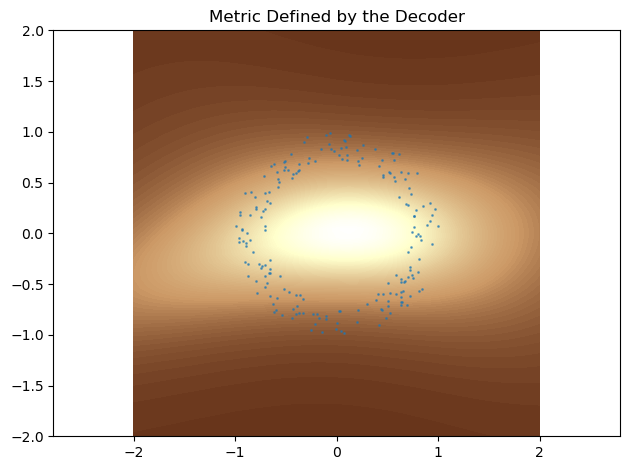

In [53]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, bg, levels=100, cmap=custom_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6)
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [38]:
ldm = DensityMetric(latents, 0.01)
lat_curve_indices = torch.randint(latents.shape[0], (num_curves, 2))  # (num_curves) x 2

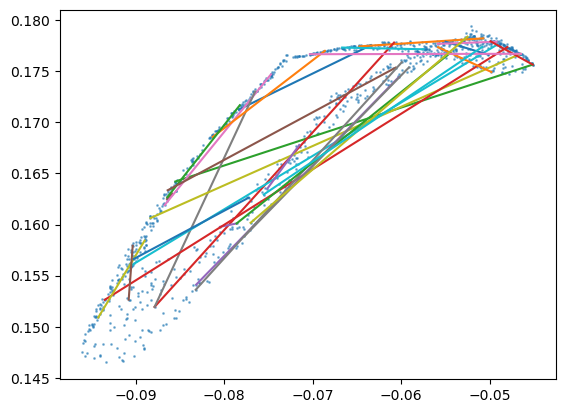

In [39]:
plt.scatter(latents[:, 0], latents[:, 1], s=1, alpha=0.5)
batch_c = CubicSpline(begin=latents[lat_curve_indices[:, 0]], end=latents[lat_curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=ldm, optimizer=torch.optim.RMSprop, max_iter=200)
batch_c.plot()
plt.show()